In [3]:
import sys
sys.path.append('../src')

from module.module import Linear, Conv1D, MaxPool1D, Flatten
from module.activation import TanH, Sigmoide, ReLU

from loss.loss import CrossEntropie, CELogSoftmax
from networks.optim import Optim
from networks.sequentiel import Sequentiel

from utils.processing import one_hot_y, normalisation
from utils.plots import plot_net, classification_report

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

In [7]:
dt = pd.read_csv("../data/fashion-mnist_train.csv")

X = dt.drop(["label"], axis=1).values
X = normalisation(X)
y = dt["label"].values

indices = np.random.permutation(len(X))
X = X[indices]
y = y[indices]

In [8]:
X, _, y, _ = train_test_split(X, y, stratify=y, test_size=0.8)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [10]:
classes = len(np.unique(y))

input_neurons = X_train.shape[1]
output_neurons = classes

In [11]:
y_one_hot = one_hot_y(y_train, classes)

In [12]:
y_one_hot.shape

(9000, 10)

In [13]:
X_conv = X_train[:,:,np.newaxis]
X_conv.shape

(9000, 784, 1)

In [14]:
np.random.seed(42)

net = Sequentiel([
    Conv1D(k_size=3, chan_in=1, chan_out=32, stride=2, init="xavier"),
    MaxPool1D(2, 2), 
    Flatten(),
    Linear(6240, 3000, init="xavier"),
    ReLU(),
    Linear(3000, 500, init="xavier"),
    ReLU(),
    Linear(500, 100, init="xavier"),
    ReLU(),
    Linear(100, 10, init="xavier"),
], classes_type="multi")

optim = Optim(net, CELogSoftmax(), eps=1e-5)
optim.SGD(X_conv, y_one_hot, test_train_split=True, batch_size=50, epochs=10, verbose=True)

plot_net(optim, X_conv, y_one_hot, net_type="multiclass", net_title="Conv multi-classification")

 10%|█         | 1/10 [01:10<10:30, 70.08s/it]

Epoch 1/10 - Loss: 2.305581601551123 - Score: 0.09388888888888888


 20%|██        | 2/10 [02:23<09:34, 71.86s/it]

Epoch 2/10 - Loss: 2.3016352596481098 - Score: 0.10388888888888889


 20%|██        | 2/10 [02:33<10:12, 76.60s/it]


KeyboardInterrupt: 

In [9]:
net.score(X_test[:,:,np.newaxis], y_test)

0.297

In [10]:
yhat = net.predict(X_test[:,:,np.newaxis])

In [11]:
yhat = yhat.reshape(-1)

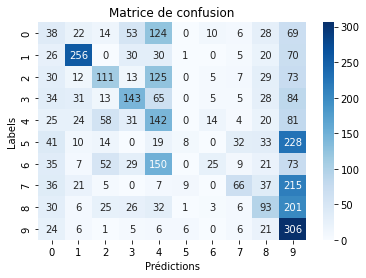

In [12]:
df = classification_report(y_test, yhat, [f"{i}" for i in range(classes)])

In [13]:
print(df.to_latex(float_format="{:.2f}".format))

\begin{tabular}{lrllr}
\toprule
{} &  precision & recall & f1-score &  support \\
class    &            &        &          &          \\
\midrule
0        &       0.12 &   0.10 &     0.11 &      364 \\
1        &       0.65 &   0.58 &     0.61 &      438 \\
2        &       0.38 &   0.27 &     0.32 &      405 \\
3        &       0.43 &   0.35 &     0.39 &      408 \\
4        &       0.20 &   0.36 &     0.26 &      399 \\
5        &       0.32 &   0.02 &     0.04 &      385 \\
6        &       0.40 &   0.06 &     0.11 &      401 \\
7        &       0.45 &   0.17 &     0.24 &      396 \\
8        &       0.28 &   0.22 &     0.25 &      423 \\
9        &       0.22 &   0.80 &     0.34 &      381 \\
accuracy &       0.30 &        &          &     4000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_83987/2413356786.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(float_format="{:.2f}".format))


/home/amayas/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/amayas/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


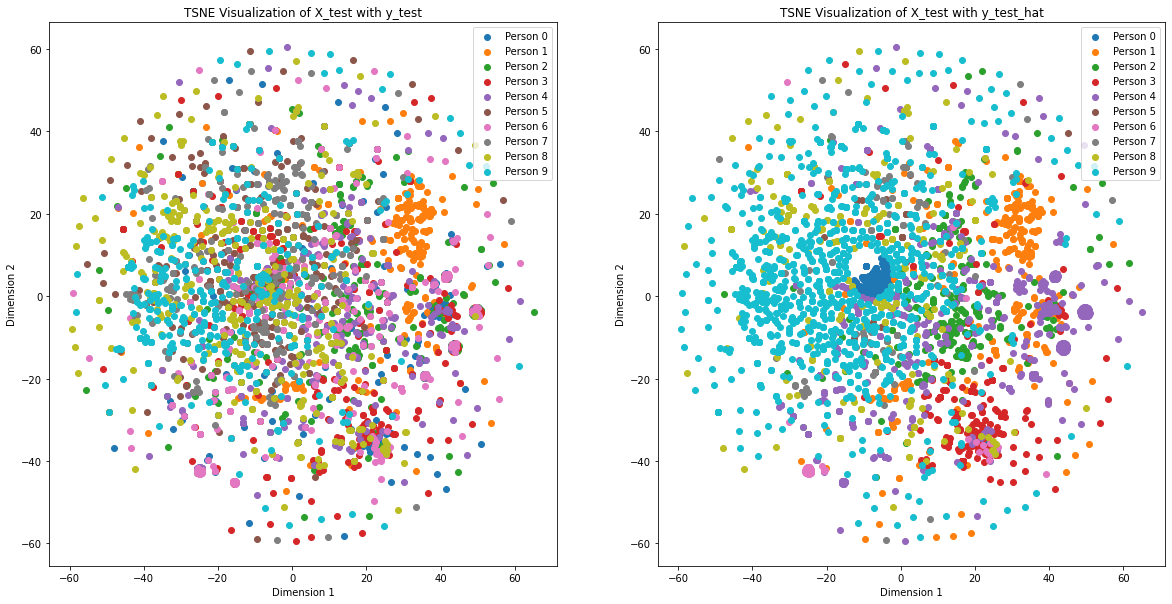

In [18]:
aff = TSNE(n_components=2, random_state=0, init="pca", n_iter=500, verbose=0)
sign_aff = aff.fit_transform(X_test)

colors = {i: plt.cm.tab10(i) for i in range(classes)}

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].set_title("TSNE Visualization of X_test with y_test")

for cl in range(classes):
    axs[0].scatter(sign_aff[y_test == cl][:, 0], sign_aff[y_test == cl][:, 1], color=colors[cl], label=f"Person {cl}")
    
axs[0].set_xlabel("Dimension 1")
axs[0].set_ylabel("Dimension 2")
axs[0].legend()

y_test_hat = net.predict(X_test[:,:,np.newaxis]).reshape(-1)

axs[1].set_title("TSNE Visualization of X_test with y_test_hat")
for cl in range(classes):
    axs[1].scatter(sign_aff[y_test_hat == cl][:, 0], sign_aff[y_test_hat == cl][:, 1], color=colors[cl], label=f"Person {cl}")
    
axs[1].set_xlabel("Dimension 1")
axs[1].set_ylabel("Dimension 2")
axs[1].legend()

plt.show()